# What is about ?


Here we consider ML approach - see https://www.kaggle.com/competitions/santa-2023/discussion/466399

With the addition of the new idea - random walks drift by the ML-model prediction . 



In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import time
t0start = time.time() 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session   

def print_inf(numpy_array):
    print(numpy_array.shape, numpy_array.nbytes,numpy_array.dtype)    
    

/kaggle/input/santa23-globe26-puzzles-states/states_on_distance_8_globe_26_npint8_solstateIX0_shape36_179716236.npy
/kaggle/input/santa23-globe26-puzzles-states/states_on_distance_7_globe_26_npint8_solstateIX0_shape36_25400414.npy
/kaggle/input/santa23-globe26-puzzles-states/vec_hash_globe_26_till8solstateIX0.npy
/kaggle/input/santa23-globe26-puzzles-states/states_on_distance_1_globe_26_npint8_solstateIX0_shape36_18.npy
/kaggle/input/santa23-globe26-puzzles-states/moves_names_globe_26_count30.csv
/kaggle/input/santa23-globe26-puzzles-states/states_on_distance_3_globe_26_npint8_solstateIX0_shape36_3458.npy
/kaggle/input/santa23-globe26-puzzles-states/states_on_distance_6_globe_26_npint8_solstateIX0_shape36_3382271.npy
/kaggle/input/santa23-globe26-puzzles-states/df_initial_states_globe_26_solstateIX0_shape5_6.csv
/kaggle/input/santa23-globe26-puzzles-states/states_on_distance_5_globe_26_npint8_solstateIX0_shape36_399824.npy
/kaggle/input/santa23-globe26-puzzles-states/states_on_distance

# Key params - choose puzzle, etc 

In [2]:
puzzle_type_main = 'globe_2/6'
index_initial_state = 357
# 'globe_2/6':
# 353	-r1.-r1.-r1.-r1.f4.f0.f10.f3.f11.-r2.f10.f9.f1...	23
# 354	r2.f6.f7.f5.-r0.f1.f0.-r2.-r2.f9.f10.f0.f11.r0...	23
# 355	r2.f4.-r2.f2.f7.-f2.r2.-f4.-f11.f1.r2.f4.f8.-f...	407
# 356	f8.f0.-r1.-r1.f9.f8.f4.r0.f5.f8.f0.f9.-f8.f4.r...	415
# 357	-r0.r1.-f6.r2.-f0.r2.-f1.f10.f0.f5.f2.-f0.f1.f...	335

prm_bound_on_steps_of_random_walks_to_be_included_into_train_set  = 40
n_random_walks = 20_000
n_steps_random_walk = 31 # length of model-guided random walks - the bigger - easier to find the solution, but it will be less optimal 
n_best_model_candidates_to_choose_for_random_walk  = 3 # we randomly choose one among that number of model best candidates and random walk steps in that direction

test_size = 0.1 # Test size for ML-model - basically we do NOT need any test, cause our test is to find solution state, any way we can keep it for sanity check

In [3]:
print(puzzle_type_main,index_initial_state, n_random_walks, n_steps_random_walk , test_size )

globe_2/6 357 20000 31 0.1


# Load current puzzle states (and solution) data

vec_initial_state - initial state in numeric format - for puzzle index_initial_state

In [4]:
%%time

fn = '/kaggle/input/santa23-globe26-puzzles-states/df_initial_states_globe_26_solstateIX0_shape5_6.csv'
dfi = pd.read_csv(fn,index_col = 0)
display( dfi )
# mask = dfi['puzzle_type'] ==  puzzle_type_main
# print(mask.sum())

# fn = '/kaggle/input/santa23-submits/submission_753438_include_anna_work.csv'
# fn = '/kaggle/input/santa23-submits/submission_742860.csv'
# 353	-r1.-r1.-r1.-r1.f4.f0.f10.f3.f11.-r2.f10.f9.f1...	23
# 354	r2.f6.f7.f5.-r0.f1.f0.-r2.-r2.f9.f10.f0.f11.r0...	23
# 355	r2.f4.-r2.f2.f7.-f2.r2.-f4.-f11.f1.r2.f4.f8.-f...	407
# 356	f8.f0.-r1.-r1.f9.f8.f4.r0.f5.f8.f0.f9.-f8.f4.r...	415
# 357	-r0.r1.-f6.r2.-f0.r2.-f1.f10.f0.f5.f2.-f0.f1.f...	335
# fn = '/kaggle/input/santa23-submits/submission_720813.csv'
# fn = '/kaggle/input/santa23-submits/submission_720601_update_globe_26_355_to_37_steps.csv'
fn = '/kaggle/input/santa23-submits/submission_720173.csv'
fn_save_submit = fn
df_sub = pd.read_csv(fn, index_col = 0 )
df_sub['n_moves'] = df_sub['moves'].apply(lambda x: len(x.split('.')) )
list_moves_names = df_sub.loc[index_initial_state,'moves'].split('.')
print(len(list_moves_names), list_moves_names )
display(df_sub[ df_sub.index.isin(dfi.index)] )
display(df_sub)

import re
input_string = dfi['vec_initial_state'].at[index_initial_state]#.replace('')
print(input_string)
# Extract numbers using regular expression
numbers = re.findall(r'\d+', input_string)
print(numbers)
# Convert the extracted numbers to a list of integers
result_list = [int(num) for num in numbers]
result_list
vec_initial_state = np.array(result_list, dtype = np.int8)
print('vec_initial_state:', len(vec_initial_state) , vec_initial_state)

input_string = dfi['vec_solution_state'].at[index_initial_state]#.replace('')
print(input_string)
# Extract numbers using regular expression
numbers = re.findall(r'\d+', input_string)
print(numbers)
# Convert the extracted numbers to a list of integers
result_list = [int(num) for num in numbers]
result_list
vec_solution_state = np.array(result_list, dtype = np.int8)
print('vec_solution_state:', len(vec_solution_state) , vec_solution_state)




,puzzle_type,solution_state,initial_state,num_wildcards,vec_solution_state,vec_initial_state
id,,,,,,
353,globe_2/6,A;A;A;D;D;D;G;G;G;J;J;J;B;B;B;E;E;E;H;H;H;K;K;...,C;F;A;F;L;J;L;D;G;C;G;J;E;E;H;H;H;K;K;K;B;B;B;...,4,"[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, ...","[8, 9, 0, 9, 11, 3, 11, 1, 2, 8, 2, 3, 5, 5, 6..."
354,globe_2/6,A;A;A;D;D;D;G;G;G;J;J;J;B;B;B;E;E;E;H;H;H;K;K;...,F;J;A;L;D;L;D;I;C;I;I;A;B;B;B;E;E;E;H;H;H;K;K;...,0,"[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, ...","[9, 3, 0, 11, 1, 11, 1, 10, 8, 10, 10, 0, 4, 4..."
355,globe_2/6,A;A;A;D;D;D;G;G;G;J;J;J;B;B;B;E;E;E;H;H;H;K;K;...,F;J;J;A;D;I;D;L;I;I;C;F;E;E;H;H;H;K;K;K;B;B;B;...,0,"[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, ...","[9, 3, 3, 0, 1, 10, 1, 11, 10, 10, 8, 9, 5, 5,..."
356,globe_2/6,A;A;A;D;D;D;G;G;G;J;J;J;B;B;B;E;E;E;H;H;H;K;K;...,L;F;C;D;G;C;A;I;D;L;G;L;B;B;E;E;E;H;H;H;K;K;K;...,0,"[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, ...","[11, 9, 8, 1, 2, 8, 0, 10, 1, 11, 2, 11, 4, 4,..."
357,globe_2/6,A;A;A;D;D;D;G;G;G;J;J;J;B;B;B;E;E;E;H;H;H;K;K;...,A;L;G;F;C;D;D;F;I;F;D;G;E;E;E;H;H;H;K;K;K;B;B;...,2,"[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, ...","[0, 11, 2, 9, 8, 1, 1, 9, 10, 9, 1, 2, 5, 5, 5..."


202 ['-r0', 'r1', '-f6', 'r2', '-f0', 'r2', '-f1', 'f10', 'f0', 'f5', 'f2', '-f0', 'f1', 'r0', 'r0', '-r1', '-r1', '-r1', '-r1', '-f6', '-r2', 'f1', 'f10', 'r0', 'r0', 'f10', 'r2', 'r2', 'f4', 'f11', '-f0', '-f10', 'f9', '-r2', '-f0', '-r0', '-f11', '-f0', '-r2', 'f7', 'r2', 'f1', 'f2', 'r0', 'f2', 'f6', '-f11', 'f10', 'f8', '-f9', '-f0', '-f8', '-f0', '-f5', '-f0', '-f7', '-f0', 'f5', 'f0', 'f9', 'f0', '-r0', '-f4', 'r0', 'f0', 'f9', 'f0', 'r2', '-f7', 'r0', '-f7', '-r0', 'f2', 'r0', 'f2', '-r0', '-f6', 'r0', '-r2', '-f3', 'r2', 'f0', 'f9', 'f0', '-r2', '-f3', 'r2', 'f10', '-r0', 'f10', '-r2', 'r2', '-f11', '-r0', '-f0', 'r0', 'r0', '-f5', '-r0', '-f5', 'r0', 'f10', '-r0', 'f10', '-r2', '-r0', 'f3', 'r0', '-f0', '-f10', '-f0', '-r0', 'f3', 'r0', 'f7', '-r0', '-r0', 'f7', '-f8', '-f9', 'r0', 'f3', 'r0', '-f0', '-f10', '-f0', '-r0', 'f3', 'r0', '-r2', '-f11', '-f8', '-f11', 'r2', '-f11', '-f8', '-f11', 'f6', '-f4', '-r2', '-r2', '-f10', '-r0', '-r0', '-f10', '-r2', '-r2', '-f0', '-r0', 

,moves,n_moves
id,,
353,-r1.-r1.-r1.-r1.f4.f0.f10.f3.f11.-r2.f10.f9.f1...,23
354,r2.f6.f7.f5.-r0.f1.f0.-r2.-r2.f9.f10.f0.f11.r0...,23
355,-f1.-f8.f11.r0.-f3.-f5.-f6.-r1.-f4.-r0.-f6.-f1...,37
356,f8.-r0.-r0.-r0.-r0.-r0.-r0.f5.-r1.f4.f1.f0.f11...,219
357,-r0.r1.-f6.r2.-f0.r2.-f1.f10.f0.f5.f2.-f0.f1.r...,202


,moves,n_moves
id,,
0,r1.-f1,2
1,f0.r1.f1.-d0.-d0.-f0.-r0.f0.d0,9
2,-d1.-r0.f0.-r1.f1.d1.-r1.-f0.d1.f0.d1.d1,12
3,-f0.d0.-r0.f0.-d0.-r0.d0.-f0.-r0.-f0,10
4,-r1.-f0.d0.r0.-d1.-d1.r1.d1.f0.r1.-d1.-r1,12
...,...,...
393,f19.f21.-f39.f20.f2.-f5.f7.-r3.f55.-f12.f65.-f...,29562
394,-f31.-f22.f16.-f17.-f13.-f24.-f14.f2.f21.f44.f...,28657
395,-r0.-f42.-f8.f16.-f49.f14.-f1.f56.f26.f35.f62....,28758


[0, 11, 2, 9, 8, 1, 1, 9, 10, 9, 1, 2, 5, 5, 5, 6, 6, 6, 7, 7, 7, 4, 4, 4, 8, 0, 11, 3, 11, 8, 3, 2, 10, 3, 0, 10]
['0', '11', '2', '9', '8', '1', '1', '9', '10', '9', '1', '2', '5', '5', '5', '6', '6', '6', '7', '7', '7', '4', '4', '4', '8', '0', '11', '3', '11', '8', '3', '2', '10', '3', '0', '10']
vec_initial_state: 36 [ 0 11  2  9  8  1  1  9 10  9  1  2  5  5  5  6  6  6  7  7  7  4  4  4
  8  0 11  3 11  8  3  2 10  3  0 10]
[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11]
['0', '0', '0', '1', '1', '1', '2', '2', '2', '3', '3', '3', '4', '4', '4', '5', '5', '5', '6', '6', '6', '7', '7', '7', '8', '8', '8', '9', '9', '9', '10', '10', '10', '11', '11', '11']
vec_solution_state: 36 [ 0  0  0  1  1  1  2  2  2  3  3  3  4  4  4  5  5  5  6  6  6  7  7  7
  8  8  8  9  9  9 10 10 10 11 11 11]
CPU times: user 197 ms, sys: 23.3 ms, total: 220 ms
Wall time: 290 ms


# Load data to train the model -  (states beyond fully charted neigbourhood - obtained by random walks)

In [5]:
%%time
# /kaggle/input/santa23-globe26-puzzles-states/Globe26RandomWalksDataID4733size1mioCheck4/RW_globe_26_array_new_states_total_depth100_nstates1000000_ID4733.npy
# /kaggle/input/santa23-globe26-puzzles-states/Globe26RandomWalksDataID4733size1mioCheck4/RW_globe_26_vec_hash_depth100_nstates1000000_ID4733.npy
# /kaggle/input/santa23-globe26-puzzles-states/Globe26RandomWalksDataID4733size1mioCheck4/RW_globe_26_vec_distances_depth100_nstates1000000_ID4733.npy

dn = '/kaggle/input/santa23-globe26-puzzles-states/Globe26RandomWalksDataID4733size1mioCheck4/'
l = os.listdir(dn)
print(l)
states = np.load(dn + 'RW_globe_26_array_new_states_total_depth100_nstates1000000_ID4733.npy')
print_inf(states)
vec_hash = np.load(dn + 'RW_globe_26_vec_hash_depth100_nstates1000000_ID4733.npy')
print_inf(vec_hash)
vec_distances = np.load(dn + 'RW_globe_26_vec_distances_depth100_nstates1000000_ID4733.npy')
print_inf(vec_distances)



['RW_globe_26_array_new_states_total_depth100_nstates1000000_ID4733.npy', 'RW_globe_26_vec_hash_depth100_nstates1000000_ID4733.npy', 'RW_globe_26_vec_distances_depth100_nstates1000000_ID4733.npy']
(36, 1000000) 36000000 int8
(1000000,) 8000000 int64
(1000000,) 8000000 int64
CPU times: user 11.3 ms, sys: 52.9 ms, total: 64.2 ms
Wall time: 596 ms


# Choose part for training set

In [6]:
bound = prm_bound_on_steps_of_random_walks_to_be_included_into_train_set # 40
IX = np.where(vec_distances <= bound )[0]
print(len(IX))
IX_selected = IX

320000


# Train-test split

In [7]:
%%time

# test_size = 0.1

from sklearn.model_selection import train_test_split

IX_train, IX_test = train_test_split( IX_selected , test_size=test_size, random_state=42)
IX_train.shape, IX_test.shape 

CPU times: user 106 ms, sys: 37.5 ms, total: 143 ms
Wall time: 300 ms


((288000,), (32000,))

In [8]:
X_train, X_test, y_train, y_test = states.T[IX_train,:],states.T[IX_test,:], vec_distances[IX_train], vec_distances[IX_test]
print_inf(X_train)


(288000, 36) 10368000 int8


# Train model

iterations,  depth 10000 12
R-squared score: 0.5449778672321939
Pearson correlation score: 0.7454547829873828


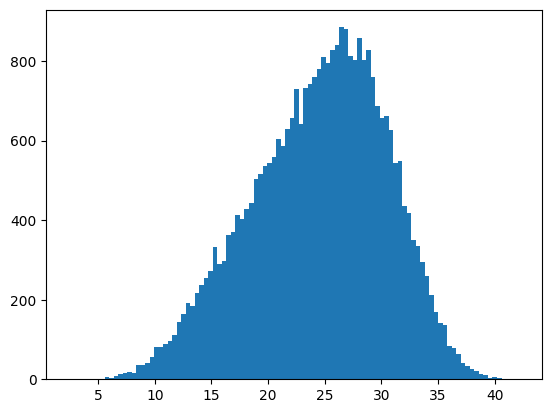

R-squared score: 0.9441011308770362
Pearson correlation score: 0.9811538778853931


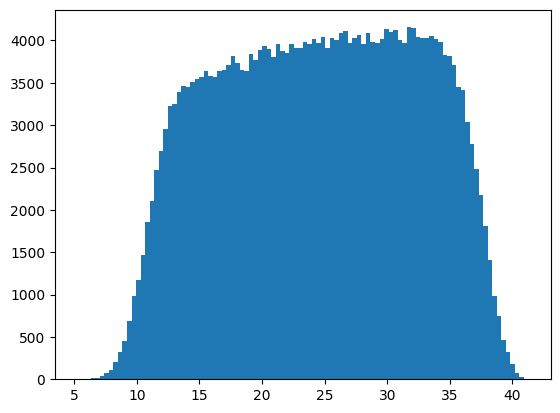

time 2087.277636051178





CPU times: user 2h 10min 8s, sys: 1min 7s, total: 2h 11min 15s
Wall time: 34min 47s


In [9]:
%%time

# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(states.T[IX_selected,:], vec_distances[IX_selected], test_size=0.5, random_state=42)
# X_train, X_test, y_train, y_test = states.T[IX_train,:],states.T[IX_test,:], vec_distances[IX_train], vec_distances[IX_test]
# print_inf(X_train)

import catboost
from catboost import CatBoostRegressor, Pool

for iterations in [10000]:# [50,500, 5000, 50_000]:
    for depth in [12]: #3,6,7,10, 12,14,16]:
        t0 = time.time()
        print('iterations,  depth', iterations,  depth)
        model = CatBoostRegressor(verbose=0, iterations=iterations,  # Number of boosting iterations
                                  depth=depth,        # Depth of the trees
                                 )
        #                           learning_rate=0.1,  # Learning rate
        #                           loss_function='RMSE',  # Specify your loss function (e.g., RMSE for regression)
        #                           cat_features=categorical_features,  # Categorical features
        #                           verbose=0)  # Set verbose to 0 to suppress output

        model.fit(X_train, y_train)

        # 100_000 Wall time: 21.3 s
        # 900_000 Wall time  180 s = 3min

        # N = 100_000
        N = len(y_test)
        y_test_loc = y_test[:N]
        y_pred = model.predict(X_test[:N,:])
        from sklearn.metrics import r2_score
        r2 = r2_score(y_test_loc, y_pred)
        print(f'R-squared score: {r2}')
        corr = np.corrcoef( y_test_loc, y_pred)[0,1]
        print(f'Pearson correlation score: {corr}')
        plt.hist(y_pred, bins = 100)
        plt.show()


        y_pred = model.predict(X_train)
        r2 = r2_score(y_train, y_pred)
        print(f'R-squared score: {r2}')
        corr = np.corrcoef( y_train, y_pred)[0,1]
        print(f'Pearson correlation score: {corr}')
        plt.hist(y_pred, bins = 100)
        plt.show()

        print('time', time.time() - t0 )
        print(); print();print();print();print();
        # Distance < 20
        # (55000, 36) 1980000 int8
        # R-squared score: 0.22630586744204906
        # Pearson correlation score: 0.4785840616267646
        # CPU times: user 43.1 s, sys: 1.52 s, total: 44.6 s
        # Wall time: 13.2 s

        # 40, 0.5
        # R-squared score: 0.37712647629640383
        # Pearson correlation score: 0.615966159849377
        # CPU times: user 1min 47s, sys: 1.73 s, total: 1min 49s
        # Wall time: 30.9 s


# Prepare for the ML-model drifted random walk

# Load data for N-neigbourhood of the solution state

Typically ALL states around the solution state till some depth - say 8 

(May include some other states also - states from which we know root to solution, easy to check) 


In [10]:
%%time
fn = '/kaggle/input/santa23-globe26-puzzles-states/distances_globe_26_till8solstateIX0.npy'
vec_distances_around_solution_state = np.load(fn)
print_inf(vec_distances_around_solution_state )
fn = '/kaggle/input/santa23-globe26-puzzles-states/vec_hash_globe_26_till8solstateIX0.npy'
vec_hash_around_solution_state = np.load(fn)
print_inf(vec_hash_around_solution_state )
fn = '/kaggle/input/santa23-globe26-puzzles-states/vec_to_create_hash.npy'
vec_to_create_hash = np.load(fn)
print_inf(vec_to_create_hash )

IX_sort_vec_hash_around_solution_state  = np.argsort(vec_hash_around_solution_state)
vec_hash_around_solution_state_sorted = vec_hash_around_solution_state[IX_sort_vec_hash_around_solution_state] # To speed-up later search 
print_inf( vec_hash_around_solution_state_sorted )


(208942509,) 1671540072 int64
(208942509,) 1671540072 int64
(36,) 288 int64
(208942509,) 1671540072 int64
CPU times: user 17.1 s, sys: 4.88 s, total: 22 s
Wall time: 47.8 s


# Load all moves matrices (v-stacked)

In [11]:
%%time
# fn = '/kaggle/input/santa23-cube2x2x2-states/all_move_matrices_vstacked_cube_222_count12_size24.npy'
fn = '/kaggle/input/santa23-globe26-puzzles-states/all_move_matrices_vstacked_globe_26_count30_size36.npy'
all_move_matrices_vstacked = np.load(fn)
all_move_matrices_vstacked

CPU times: user 2.29 ms, sys: 0 ns, total: 2.29 ms
Wall time: 6.38 ms


array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [12]:
%%time
# fn = '/kaggle/input/santa23-cube2x2x2-states/moves_names_cube_222_count12.csv'
fn = '/kaggle/input/santa23-globe26-puzzles-states/moves_names_globe_26_count30.csv'
df_moves_names = pd.read_csv(fn, index_col = 0)
df_moves_names

CPU times: user 10 ms, sys: 0 ns, total: 10 ms
Wall time: 12.5 ms


,0
0,r0
1,r1
2,r2
3,f0
4,f1
5,f2
6,f3
7,f4
8,f5
9,f6


In [13]:
dict_move_name_to_matrix = {}
for k in range(len(df_moves_names)):
    n = all_move_matrices_vstacked.shape[1]
    mat = all_move_matrices_vstacked[k*n:(k+1)*n,:]
#     print(mat.shape)
    nm = df_moves_names.iloc[k,0]
    dict_move_name_to_matrix[nm] = mat
    print(k,nm, mat.shape)

0 r0 (36, 36)
1 r1 (36, 36)
2 r2 (36, 36)
3 f0 (36, 36)
4 f1 (36, 36)
5 f2 (36, 36)
6 f3 (36, 36)
7 f4 (36, 36)
8 f5 (36, 36)
9 f6 (36, 36)
10 f7 (36, 36)
11 f8 (36, 36)
12 f9 (36, 36)
13 f10 (36, 36)
14 f11 (36, 36)
15 -r0 (36, 36)
16 -r1 (36, 36)
17 -r2 (36, 36)
18 -f0 (36, 36)
19 -f1 (36, 36)
20 -f2 (36, 36)
21 -f3 (36, 36)
22 -f4 (36, 36)
23 -f5 (36, 36)
24 -f6 (36, 36)
25 -f7 (36, 36)
26 -f8 (36, 36)
27 -f9 (36, 36)
28 -f10 (36, 36)
29 -f11 (36, 36)


# Main Procedure - Search path to charted part - random walk with drift by ML-model

In [14]:
# 356:  [11  9  8  1  2  8  0 10  1 11  2 11  4  4  5  5  5  6  6  6  7  7  7  4   9 10  0 10  8  3  2  9  0  3  1  3]
print(vec_initial_state)

[ 0 11  2  9  8  1  1  9 10  9  1  2  5  5  5  6  6  6  7  7  7  4  4  4
  8  0 11  3 11  8  3  2 10  3  0 10]


In [15]:
print(n_random_walks, n_steps_random_walk , n_best_model_candidates_to_choose_for_random_walk)

20000 31 3


i_trial: 0 time 0.00
i_trial: 50 time 13.67
i_trial: 100 time 27.26
i_trial: 150 time 40.83
i_trial: 200 time 54.31
i_trial: 250 time 67.85
i_trial: 300 time 81.37
i_trial: 350 time 94.95
i_trial: 400 time 108.47
i_trial: 450 time 122.12
i_trial: 500 time 135.87
i_trial: 550 time 149.59
i_trial: 600 time 163.19
i_trial: 650 time 176.71
i_trial: 700 time 190.39
i_trial: 750 time 203.94
i_trial: 800 time 217.49
i_trial: 850 time 231.03
i_trial: 900 time 244.46
i_trial: 950 time 258.04
i_trial: 1000 time 271.54
i_trial: 1050 time 285.00
i_trial: 1100 time 298.57
i_trial: 1150 time 312.04
i_trial: 1200 time 325.57
i_trial: 1250 time 338.98
i_trial: 1300 time 352.47
i_trial: 1350 time 365.85
i_trial: 1400 time 379.60
i_trial: 1450 time 393.00
i_trial: 1500 time 406.56
i_trial: 1550 time 420.06
i_trial: 1600 time 433.57
i_trial: 1650 time 447.03
i_trial: 1700 time 460.52
i_trial: 1750 time 473.97
i_trial: 1800 time 487.41
i_trial: 1850 time 500.91
i_trial: 1900 time 514.56
i_trial: 1950 time

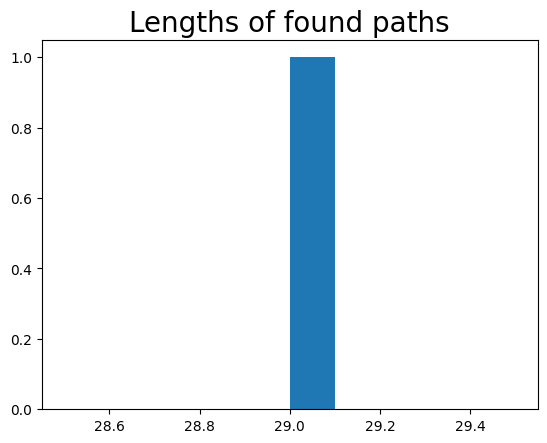

CPU times: user 1h 25min 1s, sys: 2min 57s, total: 1h 27min 58s
Wall time: 1h 20min 44s


In [16]:
%%time
import time
t0 = time.time()
n_steps_random_walk_loc = n_steps_random_walk
ms =  all_move_matrices_vstacked.shape[1]   
i_found = 0; len_shortest_found_path = np.inf; list_save_moves_shortest = []; list_lens_of_paths_found = []
for i_trial in range(n_random_walks): # n_random_walks= 10_000
    if (i_trial%50 == 0): print('i_trial:', i_trial, 'time %.2f'%(time.time() - t0 ) )
    current_state = vec_initial_state.copy()
    list_save_moves = []
    for i_step in range(1, n_steps_random_walk_loc+1): #  n_steps_random_walk = 100
        new_states_vstacked = np.dot(all_move_matrices_vstacked, current_state).reshape(-1,ms ) # Apply all moves (AT ONCE)
        dist_predicts = model.predict(new_states_vstacked)
        IX_move = np.argsort(dist_predicts)[np.random.randint(n_best_model_candidates_to_choose_for_random_walk)] # Choose randomly one of the N-best candidates by model
        list_save_moves.append(IX_move)
        current_state = new_states_vstacked[IX_move,:]
        current_hash = np.dot(vec_to_create_hash,current_state )
        IX_check_found_desired =  np.searchsorted(vec_hash_around_solution_state_sorted, [current_hash] )[0]
        if (IX_check_found_desired <  len(vec_hash_around_solution_state_sorted) ) and (vec_hash_around_solution_state_sorted[IX_check_found_desired] == current_hash):
            i_found += 1
            list_lens_of_paths_found.append( len( list_save_moves )  )
            n_steps_random_walk_loc = len( list_save_moves ) - 1 ############ Next trials we will search for SHORTER path
            # 
            print('Found. i_trial: ', i_trial , ' i_step:',  i_step, 'time: %.1f'%(time.time() - t0) )
            print('list_save_moves', list_save_moves) 
            l2 = [df_moves_names.iat[ itmp, 0 ]  for itmp in list_save_moves ]
            print(l2)
            str_path = '.'.join(map(str, l2))
            print(str_path)
            if len(list_save_moves) < len_shortest_found_path:
                list_save_moves_shortest = list_save_moves.copy()
                len_shortest_found_path = len( list_save_moves_shortest )
                print('Found shorter path. Length:', len( list_save_moves) )
            print()
            break

if i_found > 0:            
    print()
    print()
    print('Count found paths: ', i_found )
    print('Moves indexes for the shortest path:', list_save_moves_shortest )
    list_save_moves_shortest_names = [df_moves_names.iat[ itmp, 0 ]  for itmp in list_save_moves_shortest ]
    print('Names:', list_save_moves_shortest_names)
    str_path_first_stage_random_walk_search = '.'.join(map(str, list_save_moves_shortest_names))
    print('String format:', str_path_first_stage_random_walk_search)

    print(len(list_lens_of_paths_found), list_lens_of_paths_found )
    plt.hist(list_lens_of_paths_found)
    plt.title('Lengths of found paths', fontsize = 20 )
    plt.show()

In [17]:
# Some results

# Puzzle 355
# Found. i_trial:  546  i_step: 31 time: 396.0
# list_save_moves [19, 26, 16, 14, 22, 22, 0, 21, 23, 9, 22, 15, 24, 29, 12, 4, 16, 5, 16, 22, 16, 13, 29, 14, 23, 25, 24, 14, 7, 8, 2, 2]
# ['-f1', '-f8', '-r1', 'f11', '-f4', '-f4', 'r0', '-f3', '-f5', 'f6', '-f4', '-r0', '-f6', '-f11', 'f9', 'f1', '-r1', 'f2', '-r1', '-f4', '-r1', 'f10', '-f11', 'f11', '-f5', '-f7', '-f6', 'f11', 'f4', 'f5', 'r2', 'r2']

# Found. i_trial:  302  i_step: 28 time: 247.9
# list_save_moves [19, 26, 14, 0, 21, 23, 24, 16, 22, 15, 24, 29, 27, 16, 16, 19, 26, 16, 9, 3, 5, 8, 19, 3, 12, 26, 12, 26, 8]
# ['-f1', '-f8', 'f11', 'r0', '-f3', '-f5', '-f6', '-r1', '-f4', '-r0', '-f6', '-f11', '-f9', '-r1', '-r1', '-f1', '-f8', '-r1', 'f6', 'f0', 'f2', 'f5', '-f1', 'f0', 'f9', '-f8', 'f9', '-f8', 'f5']
# -f1.-f8.f11.r0.-f3.-f5.-f6.-r1.-f4.-r0.-f6.-f11.-f9.-r1.-r1.-f1.-f8.-r1.f6.f0.f2.f5.-f1.f0.f9.-f8.f9.-f8.f5
# Found shorter path len: 29
# list_save_moves_shortest = [19, 26, 14, 0, 21, 23, 24, 16, 22, 15, 24, 29, 27, 16, 16, 19, 26, 16, 9, 3, 5, 8, 19, 3, 12, 26, 12, 26, 8]

# Puzzle 356
# Found. i_trial:  494  i_step: 39 time: 203.8
# list_save_moves [20, 17, 6, 19, 0, 16, 21, 27, 26, 24, 24, 27, 21, 11, 25, 0, 29, 8, 18, 0, 26, 17, 12, 20, 25, 26, 2, 15, 20, 20, 20, 0, 15, 20, 5, 5, 2, 27, 10]
# ['-f2', '-r2', 'f3', '-f1', 'r0', '-r1', '-f3', '-f9', '-f8', '-f6', '-f6', '-f9', '-f3', 'f8', '-f7', 'r0', '-f11', 'f5', '-f0', 'r0', '-f8', '-r2', 'f9', '-f2', '-f7', '-f8', 'r2', '-r0', '-f2', '-f2', '-f2', 'r0', '-r0', '-f2', 'f2', 'f2', 'r2', '-f9', 'f7']
# -f2.-r2.f3.-f1.r0.-r1.-f3.-f9.-f8.-f6.-f6.-f9.-f3.f8.-f7.r0.-f11.f5.-f0.r0.-f8.-r2.f9.-f2.-f7.-f8.r2.-r0.-f2.-f2.-f2.r0.-r0.-f2.f2.f2.r2.-f9.f7
# Found shorter path len: 39

# Found in version16 https://www.kaggle.com/code/alexandervc/santa23-globe26-modeling5?scriptVersionId=159879372
# Found. i_trial:  492  i_step: 25 time: 202.4
# list_save_moves [5, 0, 16, 20, 14, 28, 15, 5, 22, 4, 29, 2, 13, 10, 10, 25, 10, 25, 18, 13, 14, 0, 23, 15, 13]
# ['f2', 'r0', '-r1', '-f2', 'f11', '-f10', '-r0', 'f2', '-f4', 'f1', '-f11', 'r2', 'f10', 'f7', 'f7', '-f7', 'f7', '-f7', '-f0', 'f10', 'f11', 'r0', '-f5', '-r0', 'f10']
# f2.r0.-r1.-f2.f11.-f10.-r0.f2.-f4.f1.-f11.r2.f10.f7.f7.-f7.f7.-f7.-f0.f10.f11.r0.-f5.-r0.f10
# Found shorter path len: 25

    

# Final steps - by charted territory 

In [18]:
# i_found = 1
# For puzzle 356 (globe 2/6)
# list_save_moves_shortest = [5, 0, 16, 20, 14, 28, 15, 5, 22, 4, 29, 2, 13, 10, 10, 25, 10, 25, 18, 13, 14, 0, 23, 15, 13]

In [19]:
%%time

def go_by_path(start_state, list_path_moves_names ):
    current_state = start_state
    for move_name in list_path_moves_names:
        #print(move_name)
        matr = dict_move_name_to_matrix[move_name]
        current_state = np.dot(matr, current_state)
    return current_state
def get_distance_to_state( vec_state ):
    hash_tmp = np.dot(vec_to_create_hash, vec_state.reshape(-1,1) )
    IX = np.where(hash_tmp == vec_hash_around_solution_state)[0]
    if len(IX) > 0:
        return vec_distances_around_solution_state[IX[0]] 
    else:
        return None 


if i_found > 0:            
    # 
    list_save_moves_shortest_names = [df_moves_names.iat[ itmp, 0 ]  for itmp in list_save_moves_shortest ]
    print(list_save_moves_shortest_names)
    str_path_first_stage_random_walk_search = '.'.join(map(str, list_save_moves_shortest_names))
    print(str_path_first_stage_random_walk_search)


    new_state = go_by_path(vec_initial_state, list_save_moves_shortest_names)
    new_state_hash = np.dot(vec_to_create_hash,  new_state)
    print('new_state', new_state)
    IX_new_state = np.where(vec_hash == new_state_hash )[0]
    print('IX_new_state:',IX_new_state)
    if len(IX_new_state)>0:
        IX_new_state = IX_new_state[0]
        print('IX_new_state:',IX_new_state)
        print('Distance:', vec_distances[IX_new_state])

    get_distance_to_state( new_state )            
    
    ms =  all_move_matrices_vstacked.shape[1]   
    distance_initial = get_distance_to_state( new_state )
    print(distance_initial, 'distance_initial')
    vec_current_state = new_state.copy()
    distance_current = distance_initial
    list_moves = []
    for i_move in range(distance_initial):
        new_states_h_stacked = np.dot( all_move_matrices_vstacked, vec_current_state).reshape(-1,ms ).T # states iobtained by all 1-moves from current - h_stacked
        for i_state in range(new_states_h_stacked.shape[1] ):
            vec_new_state_candidate = new_states_h_stacked[:, i_state ] 
            new_distance = get_distance_to_state( vec_new_state_candidate  )
            #print('new_distance',new_distance)
            if (new_distance is not None) and (distance_current > new_distance): 
                move_name = df_moves_names.iloc[i_state,0]
                print(move_name, 'decreases distance, new distance: ', new_distance )
                list_moves.append( move_name )
                vec_current_state = vec_new_state_candidate
                distance_current = new_distance
                break
        if new_distance == 0:
            print('Zero distance found')
            print('State:', vec_new_state_candidate)


    print(list_moves)
    str_path_second_stage_brute_force_search = '.'.join(map(str, list_moves))
    print('Fist stage (random walk searched) path:',str_path_first_stage_random_walk_search)
    print('Second stage (brute force)  path:',str_path_second_stage_brute_force_search)
    str_full_path = str_path_first_stage_random_walk_search + '.'+str_path_second_stage_brute_force_search
    print('str_full_path:', len(str_full_path.split('.') ),  str_full_path)
    
    print('str_full_path:', len(str_full_path.split('.') ),  str_full_path)


['-f8', 'f4', '-f0', 'r0', '-f0', '-f8', 'f4', 'f0', '-f8', '-r1', 'f3', 'f6', '-r1', '-r1', '-f5', 'r2', 'f1', 'f11', 'f3', '-r0', '-f7', 'r0', '-f11', '-f5', '-f3', '-f1', 'r2', 'f0', '-f7']
-f8.f4.-f0.r0.-f0.-f8.f4.f0.-f8.-r1.f3.f6.-r1.-r1.-f5.r2.f1.f11.f3.-r0.-f7.r0.-f11.-f5.-f3.-f1.r2.f0.-f7
new_state [11 10  9  8  8  8  2  1  1  2 11 11  4  4  4  5  5  5  6  6  6  7  7  7
  3  2  1  0  0  0 10  9 10  9  3  3]
IX_new_state: []
8 distance_initial
f2 decreases distance, new distance:  7
f3 decreases distance, new distance:  6
r0 decreases distance, new distance:  5
f3 decreases distance, new distance:  4
f2 decreases distance, new distance:  3
-r0 decreases distance, new distance:  2
f8 decreases distance, new distance:  1
f0 decreases distance, new distance:  0
Zero distance found
State: [ 0  0  0  1  1  1  2  2  2  3  3  3  4  4  4  5  5  5  6  6  6  7  7  7
  8  8  8  9  9  9 10 10 10 11 11 11]
['f2', 'f3', 'r0', 'f3', 'f2', '-r0', 'f8', 'f0']
Fist stage (random walk searched) pa

# Check solution

In [20]:
%%time
if i_found > 0:            
    vec_final_state = go_by_path(vec_initial_state, str_full_path.split('.') )
    vec_final_state
    if np.all(vec_final_state == vec_solution_state ):
        print('Check passed. Achieved solution state.')
    else:
        print('Something wrong. Solution state not achieved.')


Check passed. Achieved solution state.
CPU times: user 1.08 ms, sys: 8 µs, total: 1.09 ms
Wall time: 873 µs


# Submit file prepare 

In [21]:
%%time
if i_found > 0:            

    df_sub = pd.read_csv(fn_save_submit,index_col = 0 )
    t = df_sub.loc[index_initial_state, 'moves']
    print(type(t), len(t), t)
    display(df_sub.head(2))
    df_sub.loc[index_initial_state, 'moves'] = str_full_path
    total_moves_count = np.sum( [len(df_sub.loc[t, 'moves'].split('.')) for t in df_sub.index ])
    print(total_moves_count)
    n_for_puzzle = len(str_full_path.split('.'))
    fn = 'submission_'+str(total_moves_count) +'_'+puzzle_type_main.replace('/','')+'_puzzle'+str(index_initial_state)+'_moves'+str(n_for_puzzle ) +'.csv'
    print(fn)
    df_sub.to_csv(fn)


<class 'str'> 742 -r0.r1.-f6.r2.-f0.r2.-f1.f10.f0.f5.f2.-f0.f1.r0.r0.-r1.-r1.-r1.-r1.-f6.-r2.f1.f10.r0.r0.f10.r2.r2.f4.f11.-f0.-f10.f9.-r2.-f0.-r0.-f11.-f0.-r2.f7.r2.f1.f2.r0.f2.f6.-f11.f10.f8.-f9.-f0.-f8.-f0.-f5.-f0.-f7.-f0.f5.f0.f9.f0.-r0.-f4.r0.f0.f9.f0.r2.-f7.r0.-f7.-r0.f2.r0.f2.-r0.-f6.r0.-r2.-f3.r2.f0.f9.f0.-r2.-f3.r2.f10.-r0.f10.-r2.r2.-f11.-r0.-f0.r0.r0.-f5.-r0.-f5.r0.f10.-r0.f10.-r2.-r0.f3.r0.-f0.-f10.-f0.-r0.f3.r0.f7.-r0.-r0.f7.-f8.-f9.r0.f3.r0.-f0.-f10.-f0.-r0.f3.r0.-r2.-f11.-f8.-f11.r2.-f11.-f8.-f11.f6.-f4.-r2.-r2.-f10.-r0.-r0.-f10.-r2.-r2.-f0.-r0.-r0.f0.f4.-f0.-f7.-f0.-f6.-r2.-f6.r2.-f6.-r2.-f0.-r0.-f0.-r2.f4.r2.-f4.-r0.-f4.r0.f9.-r0.f9.-r2.-f6.f11.-r0.f11.-r2.f11.-r0.f11.-r2.f0.f7.f0.f4.-r2.f5.r2.f11.-r0.f11.-r2.-f5.-r2.f5.f1.-f6.f8.f10


,moves
id,
0,r1.-f1
1,f0.r1.f1.-d0.-d0.-f0.-r0.f0.d0


720008
submission_720008_globe_26_puzzle357_moves37.csv
CPU times: user 264 ms, sys: 22 ms, total: 286 ms
Wall time: 339 ms


# Final timing

In [22]:
print('%.1f seconds passed total '%(time.time()-t0start) )
print('%.1f minutes passed total '%( (time.time()-t0start)/60)  )
print('%.2f hours passed total '%( (time.time()-t0start)/3600)  )

7001.7 seconds passed total 
116.7 minutes passed total 
1.94 hours passed total 
